In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import numpy as np

In [2]:
seed = 221
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load datasets

In [3]:
train = pd.read_csv(r"C:\Users\cungu\Downloads\CS115\datasets\train.csv")
valid = pd.read_csv(r"C:\Users\cungu\Downloads\CS115\datasets\valid.csv")
test = pd.read_csv(r"C:\Users\cungu\Downloads\CS115\datasets\test.csv")

In [4]:
train.drop(columns=["topic"], axis=1, inplace=True)
valid.drop(columns=["topic"], axis=1, inplace=True)
test.drop(columns=["topic"], axis=1, inplace=True)

In [5]:
train = pd.concat([train, valid])

## Data Cleaning

In [6]:
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, WhitespaceTokenizer

In [7]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [8]:
train["clean_text"] = train["sentence"].apply(lambda x:remove_emojis(x))

In [9]:
def remove_url(data):
    url = re.sub(r'http\S+', '', data)
    return url
train["clean_text"] = train["clean_text"].apply(lambda x:remove_url(x))

In [10]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [11]:
train["clean_text"] = train["sentence"].apply(lambda x:remove_punctuation(x))

In [12]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    lines = [line.strip() for line in file]

print(lines)

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó', 'alô', 'amen', 'anh', 'anh ấy', 'ba', 'ba ba', 'ba bản', 'ba cùng', 'ba họ', 'ba ngày', 'ba ngôi', 'ba tăng', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bao nả', 'bay biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết chắc', 'biết chừng nào', 'biết mình', 'biết mấy', 'biết thế', 'biết trước', 'biết việc', 'biết đâu', 'biết đâu chừng', 'biết đâu đấy', 'biết được', 'buổi', 'buổi làm', 'buổi mới', 'buổi ngày', 'buổi sớm', 'bà', 'bà ấy', 'bài', 'bài bác', 'bài bỏ', 'bài cái', 'bác', 'bán', 'bán cấp', 'bán dạ', 'bán thế', 'bây bẩy', 'bây chừ', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bên bị', 'bên có', 'bên cạnh', 'bông', 'bước', 'bước khỏi', 'bước tới', 'bước đi', 'bạn', 'bản', 'bản bộ', 'bản riêng', 'bản thân', 'bản ý', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất quá chỉ', 'bất thình lình', 'bất tử', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâ

In [13]:
vietnamese_stopwords = ['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó', 'alô', 'amen', 'anh', 'anh ấy', 'ba', 'ba ba', 'ba bản', 'ba cùng', 'ba họ', 'ba ngày', 'ba ngôi', 'ba tăng', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bao nả', 'bay biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết chắc', 'biết chừng nào', 'biết mình', 'biết mấy', 'biết thế', 'biết trước', 'biết việc', 'biết đâu', 'biết đâu chừng', 'biết đâu đấy', 'biết được', 'buổi', 'buổi làm', 'buổi mới', 'buổi ngày', 'buổi sớm', 'bà', 'bà ấy', 'bài', 'bài bác', 'bài bỏ', 'bài cái', 'bác', 'bán', 'bán cấp', 'bán dạ', 'bán thế', 'bây bẩy', 'bây chừ', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bên bị', 'bên có', 'bên cạnh', 'bông', 'bước', 'bước khỏi', 'bước tới', 'bước đi', 'bạn', 'bản', 'bản bộ', 'bản riêng', 'bản thân', 'bản ý', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất quá chỉ', 'bất thình lình', 'bất tử', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâu nay', 'bấy nay', 'bấy nhiêu', 'bập bà bập bõm', 'bập bõm', 'bắt đầu', 'bắt đầu từ', 'bằng', 'bằng cứ', 'bằng không', 'bằng người', 'bằng nhau', 'bằng như', 'bằng nào', 'bằng nấy', 'bằng vào', 'bằng được', 'bằng ấy', 'bển', 'bệt', 'bị', 'bị chú', 'bị vì', 'bỏ', 'bỏ bà', 'bỏ cha', 'bỏ cuộc', 'bỏ không', 'bỏ lại', 'bỏ mình', 'bỏ mất', 'bỏ mẹ', 'bỏ nhỏ', 'bỏ quá', 'bỏ ra', 'bỏ riêng', 'bỏ việc', 'bỏ xa', 'bỗng', 'bỗng chốc', 'bỗng dưng', 'bỗng không', 'bỗng nhiên', 'bỗng nhưng', 'bỗng thấy', 'bỗng đâu', 'bộ', 'bộ thuộc', 'bộ điều', 'bội phần', 'bớ', 'bởi', 'bởi ai', 'bởi chưng', 'bởi nhưng', 'bởi sao', 'bởi thế', 'bởi thế cho nên', 'bởi tại', 'bởi vì', 'bởi vậy', 'bởi đâu', 'bức', 'cao', 'cao lâu', 'cao ráo', 'cao răng', 'cao sang', 'cao số', 'cao thấp', 'cao thế', 'cao xa', 'cha', 'cha chả', 'chao ôi', 'chia sẻ', 'chiếc', 'cho', 'cho biết', 'cho chắc', 'cho hay', 'cho nhau', 'cho nên', 'cho rằng', 'cho rồi', 'cho thấy', 'cho tin', 'cho tới', 'cho tới khi', 'cho về', 'cho ăn', 'cho đang', 'cho được', 'cho đến', 'cho đến khi', 'cho đến nỗi', 'choa', 'chu cha', 'chui cha', 'chung', 'chung cho', 'chung chung', 'chung cuộc', 'chung cục', 'chung nhau', 'chung qui', 'chung quy', 'chung quy lại', 'chung ái', 'chuyển', 'chuyển tự', 'chuyển đạt', 'chuyện', 'chuẩn bị', 'chành chạnh', 'chí chết', 'chính', 'chính bản', 'chính giữa', 'chính là', 'chính thị', 'chính điểm', 'chùn chùn', 'chùn chũn', 'chú', 'chú dẫn', 'chú khách', 'chú mày', 'chú mình', 'chúng', 'chúng mình', 'chúng ta', 'chúng tôi', 'chúng ông', 'chăn chắn', 'chăng', 'chăng chắc', 'chăng nữa', 'chơi', 'chơi họ', 'chưa', 'chưa bao giờ', 'chưa chắc', 'chưa có', 'chưa cần', 'chưa dùng', 'chưa dễ', 'chưa kể', 'chưa tính', 'chưa từng', 'chầm chập', 'chậc', 'chắc', 'chắc chắn', 'chắc dạ', 'chắc hẳn', 'chắc lòng', 'chắc người', 'chắc vào', 'chắc ăn', 'chẳng lẽ', 'chẳng những', 'chẳng nữa', 'chẳng phải', 'chết nỗi', 'chết thật', 'chết tiệt', 'chỉ', 'chỉ chính', 'chỉ có', 'chỉ là', 'chỉ tên', 'chỉn', 'chị', 'chị bộ', 'chị ấy', 'chịu', 'chịu chưa', 'chịu lời', 'chịu tốt', 'chịu ăn', 'chọn', 'chọn bên', 'chọn ra', 'chốc chốc', 'chớ', 'chớ chi', 'chớ gì', 'chớ không', 'chớ kể', 'chớ như', 'chợt', 'chợt nghe', 'chợt nhìn', 'chủn', 'chứ', 'chứ ai', 'chứ còn', 'chứ gì', 'chứ không', 'chứ không phải', 'chứ lại', 'chứ lị', 'chứ như', 'chứ sao', 'coi bộ', 'coi mòi', 'con', 'con con', 'con dạ', 'con nhà', 'con tính', 'cu cậu', 'cuối', 'cuối cùng', 'cuối điểm', 'cuốn', 'cuộc', 'càng', 'càng càng', 'càng hay', 'cá nhân', 'các', 'các cậu', 'cách', 'cách bức', 'cách không', 'cách nhau', 'cách đều', 'cái', 'cái gì', 'cái họ', 'cái đã', 'cái đó', 'cái ấy', 'câu hỏi', 'cây', 'cây nước', 'còn', 'còn như', 'còn nữa', 'còn thời gian', 'còn về', 'có', 'có ai', 'có chuyện', 'có chăng', 'có chăng là', 'có chứ', 'có cơ', 'có dễ', 'có họ', 'có khi', 'có ngày', 'có người', 'có nhiều', 'có nhà', 'có phải', 'có số', 'có tháng', 'có thế', 'có thể', 'có vẻ', 'có ý', 'có ăn', 'có điều', 'có điều kiện', 'có đáng', 'có đâu', 'có được', 'cóc khô', 'cô', 'cô mình', 'cô quả', 'cô tăng', 'cô ấy', 'công nhiên', 'cùng', 'cùng chung', 'cùng cực', 'cùng nhau', 'cùng tuổi', 'cùng tột', 'cùng với', 'cùng ăn', 'căn', 'căn cái', 'căn cắt', 'căn tính', 'cũng', 'cũng như', 'cũng nên', 'cũng thế', 'cũng vậy', 'cũng vậy thôi', 'cũng được', 'cơ', 'cơ chỉ', 'cơ chừng', 'cơ cùng', 'cơ dẫn', 'cơ hồ', 'cơ hội', 'cơ mà', 'cơn', 'cả', 'cả nghe', 'cả nghĩ', 'cả ngày', 'cả người', 'cả nhà', 'cả năm', 'cả thảy', 'cả thể', 'cả tin', 'cả ăn', 'cả đến', 'cảm thấy', 'cảm ơn', 'cấp', 'cấp số', 'cấp trực tiếp', 'cần', 'cần cấp', 'cần gì', 'cần số', 'cật lực', 'cật sức', 'cậu', 'cổ lai', 'cụ thể', 'cụ thể là', 'cụ thể như', 'của', 'của ngọt', 'của tin', 'cứ', 'cứ như', 'cứ việc', 'cứ điểm', 'cực lực', 'do', 'do vì', 'do vậy', 'do đó', 'duy', 'duy chỉ', 'duy có', 'dài', 'dài lời', 'dài ra', 'dành', 'dành dành', 'dào', 'dì', 'dù', 'dù cho', 'dù dì', 'dù gì', 'dù rằng', 'dù sao', 'dùng', 'dùng cho', 'dùng hết', 'dùng làm', 'dùng đến', 'dưới', 'dưới nước', 'dạ', 'dạ bán', 'dạ con', 'dạ dài', 'dạ dạ', 'dạ khách', 'dần dà', 'dần dần', 'dầu sao', 'dẫn', 'dẫu', 'dẫu mà', 'dẫu rằng', 'dẫu sao', 'dễ', 'dễ dùng', 'dễ gì', 'dễ khiến', 'dễ nghe', 'dễ ngươi', 'dễ như chơi', 'dễ sợ', 'dễ sử dụng', 'dễ thường', 'dễ thấy', 'dễ ăn', 'dễ đâu', 'dở chừng', 'dữ', 'dữ cách', 'em', 'em em', 'giá trị', 'giá trị thực tế', 'giảm', 'giảm chính', 'giảm thấp', 'giảm thế', 'giống', 'giống người', 'giống nhau', 'giống như', 'giờ', 'giờ lâu', 'giờ này', 'giờ đi', 'giờ đây', 'giờ đến', 'giữ', 'giữ lấy', 'giữ ý', 'giữa', 'giữa lúc', 'gây', 'gây cho', 'gây giống', 'gây ra', 'gây thêm', 'gì', 'gì gì', 'gì đó', 'gần', 'gần bên', 'gần hết', 'gần ngày', 'gần như', 'gần xa', 'gần đây', 'gần đến', 'gặp', 'gặp khó khăn', 'gặp phải', 'gồm', 'hay', 'hay biết', 'hay hay', 'hay không', 'hay là', 'hay làm', 'hay nhỉ', 'hay nói', 'hay sao', 'hay tin', 'hay đâu', 'hiểu', 'hiện nay', 'hiện tại', 'hoàn toàn', 'hoặc', 'hoặc là', 'hãy', 'hãy còn', 'hơn', 'hơn cả', 'hơn hết', 'hơn là', 'hơn nữa', 'hơn trước', 'hầu hết', 'hết', 'hết chuyện', 'hết cả', 'hết của', 'hết nói', 'hết ráo', 'hết rồi', 'hết ý', 'họ', 'họ gần', 'họ xa', 'hỏi', 'hỏi lại', 'hỏi xem', 'hỏi xin', 'hỗ trợ', 'khi', 'khi khác', 'khi không', 'khi nào', 'khi nên', 'khi trước', 'khiến', 'khoảng', 'khoảng cách', 'khoảng không', 'khá', 'khá tốt', 'khác', 'khác gì', 'khác khác', 'khác nhau', 'khác nào', 'khác thường', 'khác xa', 'khách', 'khó', 'khó biết', 'khó chơi', 'khó khăn', 'khó làm', 'khó mở', 'khó nghe', 'khó nghĩ', 'khó nói', 'khó thấy', 'khó tránh', 'không', 'không ai', 'không bao giờ', 'không bao lâu', 'không biết', 'không bán', 'không chỉ', 'không còn', 'không có', 'không có gì', 'không cùng', 'không cần', 'không cứ', 'không dùng', 'không gì', 'không hay', 'không khỏi', 'không kể', 'không ngoài', 'không nhận', 'không những', 'không phải', 'không phải không', 'không thể', 'không tính', 'không điều kiện', 'không được', 'không đầy', 'không để', 'khẳng định', 'khỏi', 'khỏi nói', 'kể', 'kể cả', 'kể như', 'kể tới', 'kể từ', 'liên quan', 'loại', 'loại từ', 'luôn', 'luôn cả', 'luôn luôn', 'luôn tay', 'là', 'là cùng', 'là là', 'là nhiều', 'là phải', 'là thế nào', 'là vì', 'là ít', 'làm', 'làm bằng', 'làm cho', 'làm dần dần', 'làm gì', 'làm lòng', 'làm lại', 'làm lấy', 'làm mất', 'làm ngay', 'làm như', 'làm nên', 'làm ra', 'làm riêng', 'làm sao', 'làm theo', 'làm thế nào', 'làm tin', 'làm tôi', 'làm tăng', 'làm tại', 'làm tắp lự', 'làm vì', 'làm đúng', 'làm được', 'lâu', 'lâu các', 'lâu lâu', 'lâu nay', 'lâu ngày', 'lên', 'lên cao', 'lên cơn', 'lên mạnh', 'lên ngôi', 'lên nước', 'lên số', 'lên xuống', 'lên đến', 'lòng', 'lòng không', 'lúc', 'lúc khác', 'lúc lâu', 'lúc nào', 'lúc này', 'lúc sáng', 'lúc trước', 'lúc đi', 'lúc đó', 'lúc đến', 'lúc ấy', 'lý do', 'lượng', 'lượng cả', 'lượng số', 'lượng từ', 'lại', 'lại bộ', 'lại cái', 'lại còn', 'lại giống', 'lại làm', 'lại người', 'lại nói', 'lại nữa', 'lại quả', 'lại thôi', 'lại ăn', 'lại đây', 'lấy', 'lấy có', 'lấy cả', 'lấy giống', 'lấy làm', 'lấy lý do', 'lấy lại', 'lấy ra', 'lấy ráo', 'lấy sau', 'lấy số', 'lấy thêm', 'lấy thế', 'lấy vào', 'lấy xuống', 'lấy được', 'lấy để', 'lần', 'lần khác', 'lần lần', 'lần nào', 'lần này', 'lần sang', 'lần sau', 'lần theo', 'lần trước', 'lần tìm', 'lớn', 'lớn lên', 'lớn nhỏ', 'lời', 'lời chú', 'lời nói', 'mang', 'mang lại', 'mang mang', 'mang nặng', 'mang về', 'muốn', 'mà', 'mà cả', 'mà không', 'mà lại', 'mà thôi', 'mà vẫn', 'mình', 'mạnh', 'mất', 'mất còn', 'mọi', 'mọi giờ', 'mọi khi', 'mọi lúc', 'mọi người', 'mọi nơi', 'mọi sự', 'mọi thứ', 'mọi việc', 'mối', 'mỗi', 'mỗi lúc', 'mỗi lần', 'mỗi một', 'mỗi ngày', 'mỗi người', 'một', 'một cách', 'một cơn', 'một khi', 'một lúc', 'một số', 'một vài', 'một ít', 'mới', 'mới hay', 'mới rồi', 'mới đây', 'mở', 'mở mang', 'mở nước', 'mở ra', 'mợ', 'mức', 'nay', 'ngay', 'ngay bây giờ', 'ngay cả', 'ngay khi', 'ngay khi đến', 'ngay lúc', 'ngay lúc này', 'ngay lập tức', 'ngay thật', 'ngay tức khắc', 'ngay tức thì', 'ngay từ', 'nghe', 'nghe chừng', 'nghe hiểu', 'nghe không', 'nghe lại', 'nghe nhìn', 'nghe như', 'nghe nói', 'nghe ra', 'nghe rõ', 'nghe thấy', 'nghe tin', 'nghe trực tiếp', 'nghe đâu', 'nghe đâu như', 'nghe được', 'nghen', 'nghiễm nhiên', 'nghĩ', 'nghĩ lại', 'nghĩ ra', 'nghĩ tới', 'nghĩ xa', 'nghĩ đến', 'nghỉm', 'ngoài', 'ngoài này', 'ngoài ra', 'ngoài xa', 'ngoải', 'nguồn', 'ngày', 'ngày càng', 'ngày cấp', 'ngày giờ', 'ngày ngày', 'ngày nào', 'ngày này', 'ngày nọ', 'ngày qua', 'ngày rày', 'ngày tháng', 'ngày xưa', 'ngày xửa', 'ngày đến', 'ngày ấy', 'ngôi', 'ngôi nhà', 'ngôi thứ', 'ngõ hầu', 'ngăn ngắt', 'ngươi', 'người', 'người hỏi', 'người khác', 'người khách', 'người mình', 'người nghe', 'người người', 'người nhận', 'ngọn', 'ngọn nguồn', 'ngọt', 'ngồi', 'ngồi bệt', 'ngồi không', 'ngồi sau', 'ngồi trệt', 'ngộ nhỡ', 'nhanh', 'nhanh lên', 'nhanh tay', 'nhau', 'nhiên hậu', 'nhiều', 'nhiều ít', 'nhiệt liệt', 'nhung nhăng', 'nhà', 'nhà chung', 'nhà khó', 'nhà làm', 'nhà ngoài', 'nhà ngươi', 'nhà tôi', 'nhà việc', 'nhân dịp', 'nhân tiện', 'nhé', 'nhìn', 'nhìn chung', 'nhìn lại', 'nhìn nhận', 'nhìn theo', 'nhìn thấy', 'nhìn xuống', 'nhóm', 'nhón nhén', 'như', 'như ai', 'như chơi', 'như không', 'như là', 'như nhau', 'như quả', 'như sau', 'như thường', 'như thế', 'như thế nào', 'như thể', 'như trên', 'như trước', 'như tuồng', 'như vậy', 'như ý', 'nhưng', 'nhưng mà', 'nhược bằng', 'nhất', 'nhất loạt', 'nhất luật', 'nhất là', 'nhất mực', 'nhất nhất', 'nhất quyết', 'nhất sinh', 'nhất thiết', 'nhất thì', 'nhất tâm', 'nhất tề', 'nhất đán', 'nhất định', 'nhận', 'nhận biết', 'nhận họ', 'nhận làm', 'nhận nhau', 'nhận ra', 'nhận thấy', 'nhận việc', 'nhận được', 'nhằm', 'nhằm khi', 'nhằm lúc', 'nhằm vào', 'nhằm để', 'nhỉ', 'nhỏ', 'nhỏ người', 'nhớ', 'nhớ bập bõm', 'nhớ lại', 'nhớ lấy', 'nhớ ra', 'nhờ', 'nhờ chuyển', 'nhờ có', 'nhờ nhờ', 'nhờ đó', 'nhỡ ra', 'những', 'những ai', 'những khi', 'những là', 'những lúc', 'những muốn', 'những như', 'nào', 'nào cũng', 'nào hay', 'nào là', 'nào phải', 'nào đâu', 'nào đó', 'này', 'này nọ', 'nên', 'nên chi', 'nên chăng', 'nên làm', 'nên người', 'nên tránh', 'nó', 'nóc', 'nói', 'nói bông', 'nói chung', 'nói khó', 'nói là', 'nói lên', 'nói lại', 'nói nhỏ', 'nói phải', 'nói qua', 'nói ra', 'nói riêng', 'nói rõ', 'nói thêm', 'nói thật', 'nói toẹt', 'nói trước', 'nói tốt', 'nói với', 'nói xa', 'nói ý', 'nói đến', 'nói đủ', 'năm', 'năm tháng', 'nơi', 'nơi nơi', 'nước', 'nước bài', 'nước cùng', 'nước lên', 'nước nặng', 'nước quả', 'nước xuống', 'nước ăn', 'nước đến', 'nấy', 'nặng', 'nặng căn', 'nặng mình', 'nặng về', 'nếu', 'nếu có', 'nếu cần', 'nếu không', 'nếu mà', 'nếu như', 'nếu thế', 'nếu vậy', 'nếu được', 'nền', 'nọ', 'nớ', 'nức nở', 'nữa', 'nữa khi', 'nữa là', 'nữa rồi', 'oai oái', 'oái', 'pho', 'phè', 'phè phè', 'phía', 'phía bên', 'phía bạn', 'phía dưới', 'phía sau', 'phía trong', 'phía trên', 'phía trước', 'phóc', 'phót', 'phù hợp', 'phăn phắt', 'phương chi', 'phải', 'phải biết', 'phải chi', 'phải chăng', 'phải cách', 'phải cái', 'phải giờ', 'phải khi', 'phải không', 'phải lại', 'phải lời', 'phải người', 'phải như', 'phải rồi', 'phải tay', 'phần', 'phần lớn', 'phần nhiều', 'phần nào', 'phần sau', 'phần việc', 'phắt', 'phỉ phui', 'phỏng', 'phỏng như', 'phỏng nước', 'phỏng theo', 'phỏng tính', 'phốc', 'phụt', 'phứt', 'qua', 'qua chuyện', 'qua khỏi', 'qua lại', 'qua lần', 'qua ngày', 'qua tay', 'qua thì', 'qua đi', 'quan trọng', 'quan trọng vấn đề', 'quan tâm', 'quay', 'quay bước', 'quay lại', 'quay số', 'quay đi', 'quá', 'quá bán', 'quá bộ', 'quá giờ', 'quá lời', 'quá mức', 'quá nhiều', 'quá tay', 'quá thì', 'quá tin', 'quá trình', 'quá tuổi', 'quá đáng', 'quá ư', 'quả', 'quả là', 'quả thật', 'quả thế', 'quả vậy', 'quận', 'ra', 'ra bài', 'ra bộ', 'ra chơi', 'ra gì', 'ra lại', 'ra lời', 'ra ngôi', 'ra người', 'ra sao', 'ra tay', 'ra vào', 'ra ý', 'ra điều', 'ra đây', 'ren rén', 'riu ríu', 'riêng', 'riêng từng', 'riệt', 'rày', 'ráo', 'ráo cả', 'ráo nước', 'ráo trọi', 'rén', 'rén bước', 'rích', 'rón rén', 'rõ', 'rõ là', 'rõ thật', 'rút cục', 'răng', 'răng răng', 'rất', 'rất lâu', 'rằng', 'rằng là', 'rốt cuộc', 'rốt cục', 'rồi', 'rồi nữa', 'rồi ra', 'rồi sao', 'rồi sau', 'rồi tay', 'rồi thì', 'rồi xem', 'rồi đây', 'rứa', 'sa sả', 'sang', 'sang năm', 'sang sáng', 'sang tay', 'sao', 'sao bản', 'sao bằng', 'sao cho', 'sao vậy', 'sao đang', 'sau', 'sau chót', 'sau cuối', 'sau cùng', 'sau hết', 'sau này', 'sau nữa', 'sau sau', 'sau đây', 'sau đó', 'so', 'so với', 'song le', 'suýt', 'suýt nữa', 'sáng', 'sáng ngày', 'sáng rõ', 'sáng thế', 'sáng ý', 'sì', 'sì sì', 'sất', 'sắp', 'sắp đặt', 'sẽ', 'sẽ biết', 'sẽ hay', 'số', 'số cho biết', 'số cụ thể', 'số loại', 'số là', 'số người', 'số phần', 'số thiếu', 'sốt sột', 'sớm', 'sớm ngày', 'sở dĩ', 'sử dụng', 'sự', 'sự thế', 'sự việc', 'tanh', 'tanh tanh', 'tay', 'tay quay', 'tha hồ', 'tha hồ chơi', 'tha hồ ăn', 'than ôi', 'thanh', 'thanh ba', 'thanh chuyển', 'thanh không', 'thanh thanh', 'thanh tính', 'thanh điều kiện', 'thanh điểm', 'thay đổi', 'thay đổi tình trạng', 'theo', 'theo bước', 'theo như', 'theo tin', 'thi thoảng', 'thiếu', 'thiếu gì', 'thiếu điểm', 'thoạt', 'thoạt nghe', 'thoạt nhiên', 'thoắt', 'thuần', 'thuần ái', 'thuộc', 'thuộc bài', 'thuộc cách', 'thuộc lại', 'thuộc từ', 'thà', 'thà là', 'thà rằng', 'thành ra', 'thành thử', 'thái quá', 'tháng', 'tháng ngày', 'tháng năm', 'tháng tháng', 'thêm', 'thêm chuyện', 'thêm giờ', 'thêm vào', 'thì', 'thì giờ', 'thì là', 'thì phải', 'thì ra', 'thì thôi', 'thình lình', 'thích', 'thích cứ', 'thích thuộc', 'thích tự', 'thích ý', 'thím', 'thôi', 'thôi việc', 'thúng thắng', 'thương ôi', 'thường', 'thường bị', 'thường hay', 'thường khi', 'thường số', 'thường sự', 'thường thôi', 'thường thường', 'thường tính', 'thường tại', 'thường xuất hiện', 'thường đến', 'thảo hèn', 'thảo nào', 'thấp', 'thấp cơ', 'thấp thỏm', 'thấp xuống', 'thấy', 'thấy tháng', 'thẩy', 'thậm', 'thậm chí', 'thậm cấp', 'thậm từ', 'thật', 'thật chắc', 'thật là', 'thật lực', 'thật quả', 'thật ra', 'thật sự', 'thật thà', 'thật tốt', 'thật vậy', 'thế', 'thế chuẩn bị', 'thế là', 'thế lại', 'thế mà', 'thế nào', 'thế nên', 'thế ra', 'thế sự', 'thế thì', 'thế thôi', 'thế thường', 'thế thế', 'thế à', 'thế đó', 'thếch', 'thỉnh thoảng', 'thỏm', 'thốc', 'thốc tháo', 'thốt', 'thốt nhiên', 'thốt nói', 'thốt thôi', 'thộc', 'thời gian', 'thời gian sử dụng', 'thời gian tính', 'thời điểm', 'thục mạng', 'thứ', 'thứ bản', 'thứ đến', 'thửa', 'thực hiện', 'thực hiện đúng', 'thực ra', 'thực sự', 'thực tế', 'thực vậy', 'tin', 'tin thêm', 'tin vào', 'tiếp theo', 'tiếp tục', 'tiếp đó', 'tiện thể', 'toà', 'toé khói', 'toẹt', 'trong', 'trong khi', 'trong lúc', 'trong mình', 'trong ngoài', 'trong này', 'trong số', 'trong vùng', 'trong đó', 'trong ấy', 'tránh', 'tránh khỏi', 'tránh ra', 'tránh tình trạng', 'tránh xa', 'trên', 'trên bộ', 'trên dưới', 'trước', 'trước hết', 'trước khi', 'trước kia', 'trước nay', 'trước ngày', 'trước nhất', 'trước sau', 'trước tiên', 'trước tuổi', 'trước đây', 'trước đó', 'trả', 'trả của', 'trả lại', 'trả ngay', 'trả trước', 'trếu tráo', 'trển', 'trệt', 'trệu trạo', 'trỏng', 'trời đất ơi', 'trở thành', 'trừ phi', 'trực tiếp', 'trực tiếp làm', 'tuy', 'tuy có', 'tuy là', 'tuy nhiên', 'tuy rằng', 'tuy thế', 'tuy vậy', 'tuy đã', 'tuyệt nhiên', 'tuần tự', 'tuốt luốt', 'tuốt tuồn tuột', 'tuốt tuột', 'tuổi', 'tuổi cả', 'tuổi tôi', 'tà tà', 'tên', 'tên chính', 'tên cái', 'tên họ', 'tên tự', 'tênh', 'tênh tênh', 'tìm', 'tìm bạn', 'tìm cách', 'tìm hiểu', 'tìm ra', 'tìm việc', 'tình trạng', 'tính', 'tính cách', 'tính căn', 'tính người', 'tính phỏng', 'tính từ', 'tít mù', 'tò te', 'tôi', 'tôi con', 'tông tốc', 'tù tì', 'tăm tắp', 'tăng', 'tăng chúng', 'tăng cấp', 'tăng giảm', 'tăng thêm', 'tăng thế', 'tại', 'tại lòng', 'tại nơi', 'tại sao', 'tại tôi', 'tại vì', 'tại đâu', 'tại đây', 'tại đó', 'tạo', 'tạo cơ hội', 'tạo nên', 'tạo ra', 'tạo ý', 'tạo điều kiện', 'tấm', 'tấm bản', 'tấm các', 'tấn', 'tấn tới', 'tất cả', 'tất cả bao nhiêu', 'tất thảy', 'tất tần tật', 'tất tật', 'tập trung', 'tắp', 'tắp lự', 'tắp tắp', 'tọt', 'tỏ ra', 'tỏ vẻ', 'tốc tả', 'tối ư', 'tốt', 'tốt bạn', 'tốt bộ', 'tốt hơn', 'tốt mối', 'tốt ngày', 'tột', 'tột cùng', 'tớ', 'tới', 'tới gần', 'tới mức', 'tới nơi', 'tới thì', 'tức thì', 'tức tốc', 'từ', 'từ căn', 'từ giờ', 'từ khi', 'từ loại', 'từ nay', 'từ thế', 'từ tính', 'từ tại', 'từ từ', 'từ ái', 'từ điều', 'từ đó', 'từ ấy', 'từng', 'từng cái', 'từng giờ', 'từng nhà', 'từng phần', 'từng thời gian', 'từng đơn vị', 'từng ấy', 'tự', 'tự cao', 'tự khi', 'tự lượng', 'tự tính', 'tự tạo', 'tự vì', 'tự ý', 'tự ăn', 'tựu trung', 'veo', 'veo veo', 'việc', 'việc gì', 'vung thiên địa', 'vung tàn tán', 'vung tán tàn', 'và', 'vài', 'vài ba', 'vài người', 'vài nhà', 'vài nơi', 'vài tên', 'vài điều', 'vào', 'vào gặp', 'vào khoảng', 'vào lúc', 'vào vùng', 'vào đến', 'vâng', 'vâng chịu', 'vâng dạ', 'vâng vâng', 'vâng ý', 'vèo', 'vèo vèo', 'vì', 'vì chưng', 'vì rằng', 'vì sao', 'vì thế', 'vì vậy', 'ví bằng', 'ví dù', 'ví phỏng', 'ví thử', 'vô hình trung', 'vô kể', 'vô luận', 'vô vàn', 'vùng', 'vùng lên', 'vùng nước', 'văng tê', 'vượt', 'vượt khỏi', 'vượt quá', 'vạn nhất', 'vả chăng', 'vả lại', 'vấn đề', 'vấn đề quan trọng', 'vẫn', 'vẫn thế', 'vậy', 'vậy là', 'vậy mà', 'vậy nên', 'vậy ra', 'vậy thì', 'vậy ư', 'về', 'về không', 'về nước', 'về phần', 'về sau', 'về tay', 'vị trí', 'vị tất', 'vốn dĩ', 'với', 'với lại', 'với nhau', 'vở', 'vụt', 'vừa', 'vừa khi', 'vừa lúc', 'vừa mới', 'vừa qua', 'vừa rồi', 'vừa vừa', 'xa', 'xa cách', 'xa gần', 'xa nhà', 'xa tanh', 'xa tắp', 'xa xa', 'xa xả', 'xem', 'xem lại', 'xem ra', 'xem số', 'xin', 'xin gặp', 'xin vâng', 'xiết bao', 'xon xón', 'xoành xoạch', 'xoét', 'xoẳn', 'xoẹt', 'xuất hiện', 'xuất kì bất ý', 'xuất kỳ bất ý', 'xuể', 'xuống', 'xăm xúi', 'xăm xăm', 'xăm xắm', 'xảy ra', 'xềnh xệch', 'xệp', 'xử lý', 'yêu cầu', 'à', 'à này', 'à ơi', 'ào', 'ào vào', 'ào ào', 'á', 'á à', 'ái', 'ái chà', 'ái dà', 'áng', 'áng như', 'âu là', 'ít', 'ít biết', 'ít có', 'ít hơn', 'ít khi', 'ít lâu', 'ít nhiều', 'ít nhất', 'ít nữa', 'ít quá', 'ít ra', 'ít thôi', 'ít thấy', 'ô hay', 'ô hô', 'ô kê', 'ô kìa', 'ôi chao', 'ôi thôi', 'ông', 'ông nhỏ', 'ông tạo', 'ông từ', 'ông ấy', 'ông ổng', 'úi', 'úi chà', 'úi dào', 'ý', 'ý chừng', 'ý da', 'ý hoặc', 'ăn', 'ăn chung', 'ăn chắc', 'ăn chịu', 'ăn cuộc', 'ăn hết', 'ăn hỏi', 'ăn làm', 'ăn người', 'ăn ngồi', 'ăn quá', 'ăn riêng', 'ăn sáng', 'ăn tay', 'ăn trên', 'ăn về', 'đang', 'đang tay', 'đang thì', 'điều', 'điều gì', 'điều kiện', 'điểm', 'điểm chính', 'điểm gặp', 'điểm đầu tiên', 'đành đạch', 'đáng', 'đáng kể', 'đáng lí', 'đáng lý', 'đáng lẽ', 'đáng số', 'đánh giá', 'đánh đùng', 'đáo để', 'đâu', 'đâu có', 'đâu cũng', 'đâu như', 'đâu nào', 'đâu phải', 'đâu đâu', 'đâu đây', 'đâu đó', 'đây', 'đây này', 'đây rồi', 'đây đó', 'đã', 'đã hay', 'đã không', 'đã là', 'đã lâu', 'đã thế', 'đã vậy', 'đã đủ', 'đó', 'đó đây', 'đúng', 'đúng ngày', 'đúng ra', 'đúng tuổi', 'đúng với', 'đơn vị', 'đưa', 'đưa cho', 'đưa chuyện', 'đưa em', 'đưa ra', 'đưa tay', 'đưa tin', 'đưa tới', 'đưa vào', 'đưa về', 'đưa xuống', 'đưa đến', 'được', 'được cái', 'được lời', 'được nước', 'được tin', 'đại loại', 'đại nhân', 'đại phàm', 'đại để', 'đạt', 'đảm bảo', 'đầu tiên', 'đầy', 'đầy năm', 'đầy phè', 'đầy tuổi', 'đặc biệt', 'đặt', 'đặt làm', 'đặt mình', 'đặt mức', 'đặt ra', 'đặt trước', 'đặt để', 'đến', 'đến bao giờ', 'đến cùng', 'đến cùng cực', 'đến cả', 'đến giờ', 'đến gần', 'đến hay', 'đến khi', 'đến lúc', 'đến lời', 'đến nay', 'đến ngày', 'đến nơi', 'đến nỗi', 'đến thì', 'đến thế', 'đến tuổi', 'đến xem', 'đến điều', 'đến đâu', 'đều', 'đều bước', 'đều nhau', 'đều đều', 'để', 'để cho', 'để giống', 'để không', 'để lòng', 'để lại', 'để mà', 'để phần', 'để được', 'để đến nỗi', 'đối với', 'đồng thời', 'đủ', 'đủ dùng', 'đủ nơi', 'đủ số', 'đủ điều', 'đủ điểm', 'ơ', 'ơ hay', 'ơ kìa', 'ơi', 'ơi là', 'ư', 'ạ', 'ạ ơi', 'ấy', 'ấy là', 'ầu ơ', 'ắt', 'ắt hẳn', 'ắt là', 'ắt phải', 'ắt thật', 'ối dào', 'ối giời', 'ối giời ơi', 'ồ', 'ồ ồ', 'ổng', 'ớ', 'ớ này', 'ờ', 'ờ ờ', 'ở', 'ở lại', 'ở như', 'ở nhờ', 'ở năm', 'ở trên', 'ở vào', 'ở đây', 'ở đó', 'ở được', 'ủa', 'ứ hự', 'ứ ừ', 'ừ', 'ừ nhé', 'ừ thì', 'ừ ào', 'ừ ừ', 'ử', 'alo', 'an', 'ang', 'ao', 'at', 'au', 'ay', 'bac', 'bai', 'ban', 'bang', 'bao', 'bap', 'bat', 'bay', 'ben', 'beng', 'bet', 'bi', 'bien', 'biet', 'bo', 'boi', 'bom', 'bong', 'buc', 'buoc', 'buoi', 'ca', 'cac', 'cach', 'cai', 'cam', 'can', 'cang', 'canh', 'cap', 'cat', 'cau', 'cay', 'chac', 'cham', 'chan', 'chang', 'chanh', 'chao', 'chap', 'chay', 'chet', 'chi', 'chia', 'chiec', 'chin', 'chinh', 'chiu', 'choc', 'choi', 'chon', 'chot', 'chu', 'chua', 'chuan', 'chui', 'chun', 'chuyen', 'co', 'coc', 'coi', 'cong', 'cu', 'cua', 'cuc', 'cung', 'cuoc', 'cuoi', 'cuon', 'da', 'dai', 'dan', 'danh', 'dao', 'dau', 'de', 'di', 'dip', 'du', 'dung', 'duoi', 'gan', 'gap', 'gay', 'gi', 'gia', 'giac', 'giam', 'gian', 'gio', 'gioi', 'giong', 'giu', 'giua', 'gom', 'ha', 'han', 'hau', 'hen', 'het', 'hien', 'hieu', 'hinh', 'ho', 'hoac', 'hoan', 'hoi', 'hon', 'hop', 'hu', 'it', 'ke', 'kha', 'khac', 'khach', 'khan', 'khang', 'khien', 'kho', 'khoang', 'khoi', 'khong', 'ki', 'kia', 'kien', 'ky', 'la', 'lai', 'lam', 'lan', 'lap', 'lau', 'lay', 'le', 'len', 'li', 'lien', 'liet', 'linh', 'lo', 'loai', 'loat', 'loi', 'lon', 'long', 'lu', 'luan', 'luat', 'luc', 'luon', 'luong', 'luot', 'ly', 'ma', 'manh', 'mat', 'may', 'me', 'minh', 'mo', 'moi', 'mot', 'mu', 'muc', 'muon', 'na', 'nam', 'nang', 'nao', 'nen', 'neu', 'ngan', 'ngat', 'nghi', 'nghiem', 'nghim', 'ngo', 'ngoai', 'ngoi', 'ngon', 'ngot', 'nguoi', 'nguon', 'nha', 'nham', 'nhan', 'nhang', 'nhat', 'nhe', 'nhen', 'nhi', 'nhien', 'nhiet', 'nhieu', 'nhin', 'nho', 'nhom', 'nhon', 'nhu', 'nhung', 'nhuoc', 'no', 'noc', 'noi', 'nua', 'nuc', 'nuoc', 'oai', 'oi', 'on', 'ong', 'phai', 'pham', 'phan', 'phat', 'phe', 'phi', 'phia', 'phoc', 'phong', 'phot', 'phu', 'phui', 'phuong', 'phut', 'quan', 'qui', 'quy', 'quyet', 'rang', 'rao', 'rat', 'ray', 'ren', 'rich', 'rieng', 'riet', 'riu', 'ro', 'roi', 'ron', 'rot', 'rua', 'rut', 'sa', 'sap', 'sat', 'se', 'si', 'sinh', 'som', 'song', 'sot', 'su', 'suc', 'suyt', 'ta', 'tai', 'tam', 'tan', 'tang', 'tao', 'tap', 'tat', 'te', 'ten', 'tenh', 'tha', 'thai', 'tham', 'than', 'thang', 'thao', 'thap', 'that', 'thay', 'the', 'thech', 'them', 'thi', 'thich', 'thien', 'thiet', 'thieu', 'thim', 'thinh', 'thoang', 'thoat', 'thoc', 'thoi', 'thom', 'thot', 'thu', 'thua', 'thuan', 'thuc', 'thung', 'thuoc', 'thuong', 'ti', 'tien', 'tiep', 'tiet', 'tim', 'tinh', 'tit', 'to', 'toa', 'toan', 'toc', 'toe', 'toet', 'toi', 'tong', 'tot', 'tra', 'trang', 'tranh', 'trao', 'tren', 'tret', 'treu', 'tri', 'trinh', 'tro', 'troi', 'tru', 'truc', 'trung', 'truoc', 'tu', 'tuan', 'tuc', 'tung', 'tuoi', 'tuon', 'tuong', 'tuot', 'tuu', 'tuyet', 'ua', 'ui', 'va', 'vai', 'van', 'vang', 'vao', 'vay', 've', 'vi', 'viec', 'vo', 'voi', 'von', 'vua', 'vung', 'vuot', 'vut', 'xam', 'xay', 'xech', 'xenh', 'xep', 'xiet', 'xoach', 'xoan', 'xoanh', 'xoet', 'xon', 'xu', 'xua', 'xuat', 'xue', 'xui', 'xuong', 'yeu', 'đa', 'đac', 'đach', 'đai', 'đam', 'đan', 'đanh', 'đao', 'đat', 'đau', 'đay', 'đe', 'đen', 'đeu', 'đi', 'đia', 'điem', 'đieu', 'đinh', 'đo', 'đoi', 'đon', 'đong', 'đu', 'đua', 'đung', 'đuoc']

In [14]:
def remove_stopwords(text):
    words = [word for word in text.split() if word.lower() not in vietnamese_stopwords]
    return ' '.join(words)

In [15]:
train["clean_text"] = train["clean_text"].apply(lambda x:remove_stopwords(x))

#pragma section

In [16]:
def lemmatize_spanish_word(word):
    lemmatizer = WordNetLemmatizer()
    synsets = wordnet.synsets(word, lang='spa')
    if synsets:
        lemma = synsets[0].lemmas(lang='spa')[0].name()  
        return lemma
    else:
        return word
def lemmatize_spanish_text(text):
    lemmatized_words = []
    for word in text.split():
        lemma = lemmatize_spanish_word(word)
        lemmatized_words.append(lemma)
    return ' '.join(lemmatized_words)

In [ ]:
train["clean_text"] = train["clean_text"].apply(lambda x:lemmatize_spanish_text(x))

#pragma endsection

In [19]:
train.to_csv(r"./CS115", index=False, date_format="csv")

In [20]:
df = pd.read_csv(r"C:\Users\cungu\Downloads\CS115\CS115")
df.head()

,Unnamed: 0,sentence,sentiment,clean_text
0,0,slide giáo trình đầy đủ .,2,slide giáo trình
1,1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,nhiệt tình giảng dạy gũi viên
2,2,đi học đầy đủ full điểm chuyên cần .,0,học full chuyên
3,3,chưa áp dụng công nghệ thông tin và các thiết ...,0,áp dụng công nghệ thông thiết hỗ trợ giảng dạy
4,4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,thầy giảng tập ví dụ lớp


In [21]:
df["sentiment"].unique()

array([2, 0, 1], dtype=int64)

# Bagging + TF-IDF (Base Estimator: DecisionTreeClassifier)

In [22]:
y = df[["sentiment"]]

In [49]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=221)

In [50]:
x_train = x_train["clean_text"].tolist()
x_test = x_test["clean_text"].tolist()

y_train = y_train["sentiment"].tolist()
y_test = y_test["sentiment"].tolist()

In [53]:
# Filter out NaN from x_train and corresponding y_train
filtered_x_train = []
filtered_y_train = []
for i in range(len(x_train)):
    if isinstance(x_train[i], str) and x_train[i].strip() != '':
        filtered_x_train.append(x_train[i])
        filtered_y_train.append(y_train[i])

# Filter out NaN from x_test and corresponding y_test
filtered_x_test = []
filtered_y_test = []
for i in range(len(x_test)):
    if isinstance(x_test[i], str) and x_test[i].strip() != '':
        filtered_x_test.append(x_test[i])
        filtered_y_test.append(y_test[i])


In [47]:
tfidf = TfidfVectorizer(smooth_idf=True, stop_words=vietnamese_stopwords, strip_accents="unicode", lowercase= True, encoding="utf-8")

In [54]:
encoded_x_train = tfidf.fit_transform(filtered_x_train)
encoded_x_test = tfidf.transform(filtered_x_test)

In [55]:
encoded_x_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 27947 stored elements and shape (10311, 997)>

In [57]:
encoded_x_test


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6805 stored elements and shape (2571, 997)>

# Bagging Classifier

In [58]:
bag_clf = BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=seed)

In [59]:
bag_clf

BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=221)

In [61]:
bag_clf.fit(encoded_x_train, filtered_y_train)

BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=221)

In [62]:
pred = bag_clf.predict(encoded_x_test)
pred

array([2, 2, 2, ..., 2, 2, 0])

In [64]:
print(classification_report(filtered_y_test, pred))

              precision    recall  f1-score   support

           0       0.47      0.39      0.43      1196
           1       0.00      0.00      0.00       105
           2       0.49      0.60      0.54      1270

    accuracy                           0.48      2571
   macro avg       0.32      0.33      0.32      2571
weighted avg       0.46      0.48      0.46      2571



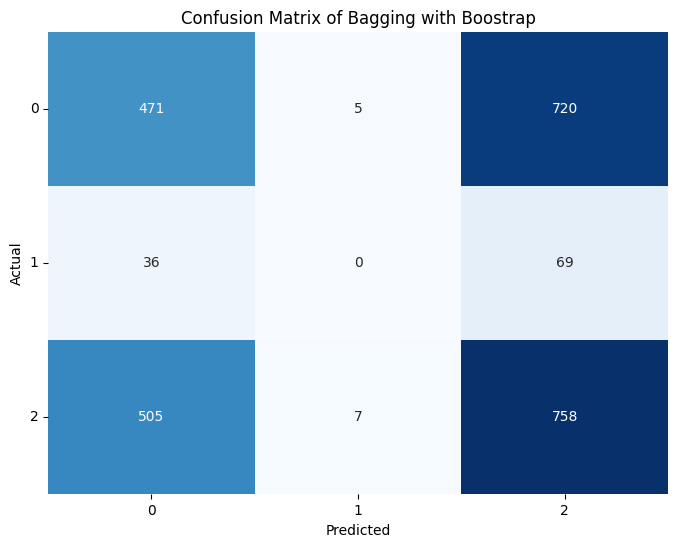

In [65]:
cm = confusion_matrix(filtered_y_test, pred)
labels = [0, 1, 2]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of Bagging with Boostrap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()

## Finetuning SVM

In [66]:
class_weights = {0: 3, 1: 1}

In [67]:
SVM_clf = svm.SVC(kernel="linear", shrinking=True, verbose=True, class_weight=class_weights ,random_state=seed)

In [68]:
SVM_clf.fit(encoded_x_train, filtered_y_train)

[LibSVM]

SVC(class_weight={0: 3, 1: 1}, kernel='linear', random_state=221, verbose=True)

In [69]:
y_pred = SVM_clf.predict(encoded_x_test)

In [70]:
print(classification_report(filtered_y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.47      0.99      0.63      1196
           1       0.00      0.00      0.00       105
           2       0.41      0.01      0.01      1270

    accuracy                           0.46      2571
   macro avg       0.29      0.33      0.21      2571
weighted avg       0.42      0.46      0.30      2571



In [71]:
print(classification_report(y_pred, filtered_y_test, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.47      0.63      2551
           1       0.00      0.00      0.00         3
           2       0.01      0.41      0.01        17

    accuracy                           0.46      2571
   macro avg       0.33      0.29      0.21      2571
weighted avg       0.98      0.46      0.63      2571



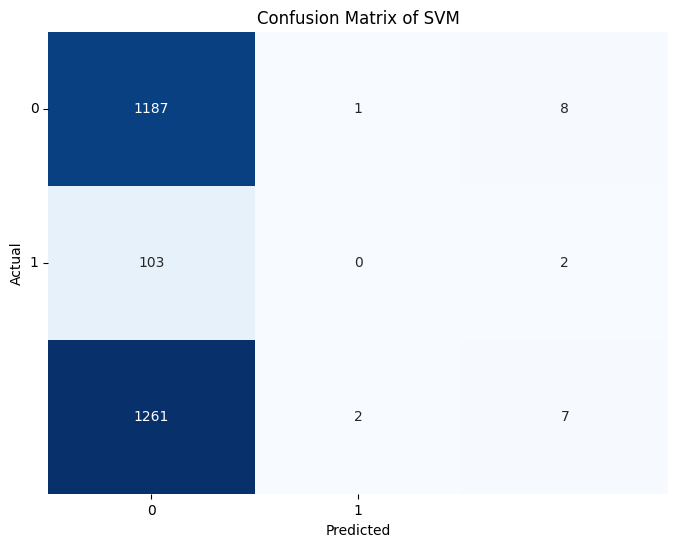

In [72]:
cm = confusion_matrix(filtered_y_test, y_pred)
labels = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()

## Random Forest

In [73]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [74]:
params = {
    "n_estimators":[25, 50],
    "criterion": ["gini", "log_loss"],
    "max_depth" : [10, 20],
    'min_samples_split': [2, 5, 10]
}

In [75]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),  # Use 'micro', 'macro', or 'weighted'
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
}

In [76]:
forest_clf = RandomForestClassifier()

In [77]:
grid_search = GridSearchCV(forest_clf, params, cv=5, scoring=scoring, refit="f1")

In [78]:
grid_search.fit(encoded_x_train, filtered_y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'log_loss'],
                         'max_depth': [10, 20], 'min_samples_split': [2, 5, 10],
                         'n_estimators': [25, 50]},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict', average=weighted, zero_division=0),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted, zero_division=0),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted, zero_division=0)})

In [79]:
best = grid_search.best_estimator_
best

RandomForestClassifier(max_depth=20, n_estimators=25)

In [80]:
y_pred_best = best.predict(encoded_x_test)
print(classification_report(filtered_y_test, y_pred_best, zero_division=0))

              precision    recall  f1-score   support

           0       0.45      0.15      0.22      1196
           1       0.00      0.00      0.00       105
           2       0.49      0.84      0.62      1270

    accuracy                           0.48      2571
   macro avg       0.31      0.33      0.28      2571
weighted avg       0.45      0.48      0.41      2571



In [81]:
random_forest = RandomForestClassifier(class_weight='balanced', criterion='entropy',max_depth=25, min_samples_split=5, random_state=221)

In [82]:
random_forest.fit(encoded_x_train, filtered_y_train)
y_pred = random_forest.predict(encoded_x_test)
print(classification_report(filtered_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.54      0.51      1196
           1       0.01      0.03      0.02       105
           2       0.50      0.40      0.44      1270

    accuracy                           0.45      2571
   macro avg       0.33      0.32      0.32      2571
weighted avg       0.47      0.45      0.46      2571



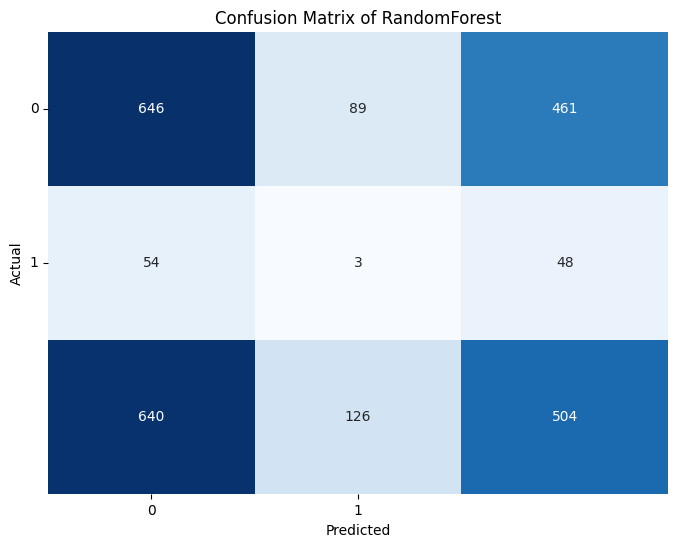

In [83]:
cm = confusion_matrix(filtered_y_test, y_pred)
labels = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of RandomForest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()